In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bokeh as bk

import panel as pn
import panel.widgets as pnw
pn.extension()


### Helper functions

In [22]:

### Used for plotting the composition heatmap
def view_composition(serotype_dictionary, include_text = False, plot_width = 800, max_num_x = 100):
    
    ### seqs: Serotype list
    ### keys: Library name
    seqs = np.array(list(serotype_dictionary.values()))
    keys = np.array(list(serotype_dictionary.keys()))
    
    N = len(seqs[0])
    S = len(seqs)    
    width = 1.
    
    tmp = [i for s in seqs for i in s]
    colors = [serotype_colors[i] for i in tmp]
    serotypes = [serotype_names[i] for i in tmp]
    
    x = np.arange(1, N + 1)
    y = np.arange(0, S, 1)    
    xx, yy = np.meshgrid(x, y)
    
    gx = xx.flatten()
    gy = yy.flatten()
    recty = gy + .1
    h = 1/S
    
    plot_height = len(seqs)*15 + 50
    x_range = bk.models.Range1d(0, N + 1, bounds = 'auto')
    if N > max_num_x:
        viewlen = max_num_x
    else:
        viewlen = N
    view_range = (0, viewlen) 
    
    
    
    source = bk.models.ColumnDataSource(dict(x=gx, y=gy, recty=recty, colors = colors, serotypes = serotypes))
    
    p = bk.plotting.figure(title = None, 
               plot_width = plot_width, plot_height = plot_height, 
               x_range = view_range, y_range = keys, tools = "xwheel_zoom, xpan, reset", 
               min_border = 0, toolbar_location = 'below')
    
    if include_text == True:
        glyph = bk.models.glyphs.Text(x="x", y="y", text="text", 
                                   text_align='center',
                                   text_color="black", 
                                   text_font="monospace",
                                   text_font_size=fontsize)
    elif include_text == False:
        glyph = bk.models.glyphs.Text(x="x", y="y", text="", 
                                   text_align='center',
                                   text_color="black", 
                                   text_font="monospace")
        
    rects = bk.models.glyphs.Rect(x = "x", y = "recty",  
                 width = 1., height = 1., 
                 fill_color = "colors", 
                 line_color = None, fill_alpha = 1.)
    
    p.add_glyph(source, glyph)
    p.add_glyph(source, rects)
  
    p.grid.visible = False
    p.xaxis.major_label_text_font_style = "bold"
    p.yaxis.minor_tick_line_width = 0
    p.yaxis.major_tick_line_width = 0
    
    
    tooltips = [("serotype", "@serotypes"),]
    p.add_tools(bk.models.HoverTool(tooltips=tooltips))
    
    return p


serotype_names = np.array(["No alignment", "AAV1", "AAV2", "AAV3", "AAV4", "AAV5", "AAV6", 
                  "AAV7", "AAV8", "AAV9", "AAV10", "AAV11", "AAV12", "AAV13", 
                  "AAVrh8", "AAVrh10", "AAVrh32", "Multiple alignments", "gap"])

### Lilit's colors:
# large_colors_list = ["#1F78B4", "#33A02C", "#C51B7D", 
#                       "#542788", "#A6CEE3", "#B2DF8A", 
#                       "#F1B6DA", "#B2ABD2", "#FFBC52", 
#                       "#E96656", "#5BBAB5", "#4C4452"]
#gs_colors_list = ["#AA4488", "#4477AA", "#AAAA44", 
#                  "#AA7744", "#AA4455", "#44AAAA", 
#                  "#771155", "#114477", "#777711", 
#                  "#774411", "#771122", "#117777"]
serotype_colors = sns.color_palette("RdBu_r", len(serotype_names) - 3).as_hex() ###
serotype_colors.insert(0, "black")
serotype_colors.append("gray")
serotype_colors.append("blue")



### Load and pre-process the files by Tatev

In [23]:
### Load the chimeric library
chimeric_library_top20_msa = pd.read_csv("Data/chimeric_lib_representatives_variant_description_top20_msa.csv", header = None)
chimeric_library = pd.read_csv("Data/chimeric_lib_representatives_variant_description.csv", header = None)

### Create a dictionaries with chimeric_name:[serotype ids]
variant_description_dictionary_top20_msa = {}
for chimeric_library_item in chimeric_library_top20_msa[0]:
    
    chimeric_library_item_name = chimeric_library_item.split()[0]
    chimeric_library_item_parents = np.array(chimeric_library_item.split()[1:]).astype("int")
    
    variant_description_dictionary_top20_msa[chimeric_library_item_name] = chimeric_library_item_parents
    
variant_description_dictionary = {}
for chimeric_library_item in chimeric_library[0]:
    
    chimeric_library_item_name = chimeric_library_item.split()[0]
    chimeric_library_item_parents = np.array(chimeric_library_item.split()[1:]).astype("int")
    
    variant_description_dictionary[chimeric_library_item_name] = chimeric_library_item_parents

### Clustering data
clustering_data = pd.read_csv("../orf_distribution/Data/clustering_info.csv")
# Introduce an additional column with member count
clustering_data["member_count"] = clustering_data["Members_char"].str.count('AAV')
# Sort the entries by the member count
clustering_data = clustering_data.sort_values(by=['member_count'])

### Combined counts
rep_counts = pd.read_csv("Data/chimeric_lib_rep_counts.csv")



### Heatmap of multiply-aligned top-20 samples

In [24]:
p = view_composition(variant_description_dictionary_top20_msa, include_text = False, 
                                                               plot_width = 800, 
                                                               max_num_x = 2500)
pn.pane.Bokeh(p)



Bokeh(Figure)

In [25]:
### Some useless table

color_source = bk.models.ColumnDataSource(dict(name = serotype_names, colors = serotype_colors))


columns = [
    bk.models.TableColumn(field='name', title='serotype_names'),
    bk.models.TableColumn(field='colors', title='colors')
    ]

serotype_table = bk.models.DataTable(source = color_source, columns = columns, fit_columns = False)

pn.pane.Bokeh(serotype_table)


Bokeh(DataTable)

### Heatmap of all the samples

In [26]:
#p = view_composition(variant_description_dictionary, include_text = False, 
#                                                               plot_width = 800, 
#                                                               max_num_x = 2500)
#pn.pane.Bokeh(p)

### Positional serotype abundance (meaningful only for MSA samaples)


In [27]:
### 2-D array of chimeric composition
chimeric_composition_array = np.array(list(variant_description_dictionary_top20_msa.values()))

### Initialize the abundance matrix ---> rows:serotypes, columns:positional abundance 
positional_serotype_abundance = np.zeros((len(serotype_names), np.shape(chimeric_composition_array)[1]))

### Populate the abundance matrix
for serotype_indx in np.arange(0, len(serotype_names), 1):
    positional_serotype_abundance[serotype_indx] = np.sum(chimeric_composition_array == serotype_indx, axis = 0)

In [42]:



##################################################################################################
##################################################################################################
def update_data(attrname, old, new):

    ### Get the current slider value
    smoothing_window_size = smoothing_slider.value
        
    smoothed_serotype_abundance = np.copy(positional_serotype_abundance)
    for serotype_indx in np.arange(0, len(serotype_names), 1):
        abundance_tmp = smoothed_serotype_abundance[serotype_indx]
        smoothed_serotype_abundance[serotype_indx] = np.convolve(abundance_tmp, 
                                                                 np.ones(smoothing_window_size), 
                                                                 'same')/smoothing_window_size
        
    ### update the data container
    source.data["abundance"] = list(smoothed_serotype_abundance)
##################################################################################################
##################################################################################################

### The smoothing slider
smoothing_slider = bk.models.Slider(start = 1, end = 500, value = 1, step = 1, title = "Smoothing length")



### Prepare the plotting data
# placeholder array
positions_base = np.arange(0, np.shape(positional_serotype_abundance)[1])
# the main data container
data_dict = {}
data_dict["positions"] = [positions_base for _ in np.arange(0, np.shape(positional_serotype_abundance)[0])]
data_dict["abundance"] = list(positional_serotype_abundance)
data_dict["color"] = serotype_colors
data_dict["serotypes"] = serotype_names
source = bk.plotting.ColumnDataSource(data = data_dict)

### Start plotting
p = bk.plotting.figure(title = "Positional counts", y_range = (-1, 10), 
                                        plot_width = 800,
                                        x_axis_label = "Position", 
                                        y_axis_label = "Serotype abundance")

p.multi_line(xs = 'positions', ys = 'abundance', source = source,
                                                 line_width = 3, 
                                                 color = 'color')

### Add a tooltip
tooltips = [("serotype", "@serotypes"),]
p.add_tools(bk.models.HoverTool(tooltips = tooltips))


smoothing_slider.on_change('value', update_data)



# show the results
layout = bk.layouts.column(smoothing_slider, p, width = 800)
pn.pane.Bokeh(layout)
#bk.plotting.output_file(filename = "positional_abundance.html", title = "Positional Abundance")
#bk.plotting.save(layout)


Bokeh(Column)

### Serotype abundance (violin plots)

In [29]:
### We compute the distribution of serotype abundance per representative
### It's a bit contrived but works fine

chimeric_representative_number, chimeric_length = np.shape(chimeric_composition_array)

distribution_serotypes = []
distribution_representatives = []

for serotype_indx in range(len(serotype_names)):
    
    ### This is not very correct for several reasons. 1) it's normlized by chimeric_length, which is the same
    ### for all the reprepsentatives because they are padded by gaps (=> many are artificially enlarged),
    ### 2) we assume all the members behave exactly as the reprepsentatives,
    ### 3) we don't account for combined counts provided by Tatev
    
    composition_tmp = 100.*np.sum(chimeric_composition_array == serotype_indx, axis = 1)/chimeric_length
    composition_tmp = np.around(composition_tmp, decimals = 2)
    
    ### This is a required for the sns violin plot
    distribution_serotypes += [serotype_names[serotype_indx]]*chimeric_representative_number
    distribution_representatives.append(list(composition_tmp))
    
distribution_serotypes = np.array(distribution_serotypes)
distribution_representatives = np.array(distribution_representatives).flatten()
    
distribution_serotypes.astype('str');
distribution_representatives.astype('float64');

print(len(distribution_serotypes) == len(distribution_representatives))

True


In [30]:
### Create a data-frame

serotype_dist_data_frame = pd.DataFrame(np.array([distribution_serotypes, distribution_representatives]).T, 
                                                  columns = ["Serotype", "Frequency"])

serotype_dist_data_frame['Frequency'] = serotype_dist_data_frame['Frequency'].astype('float64')
serotype_dist_data_frame.dtypes



Serotype      object
Frequency    float64
dtype: object

In [31]:
serotype_dist_data_frame

,Serotype,Frequency
0,No alignment,0.00
1,No alignment,0.63
2,No alignment,0.00
3,No alignment,0.00
4,No alignment,0.00
...,...,...
375,gap,6.72
376,gap,6.46
377,gap,6.59
378,gap,6.59


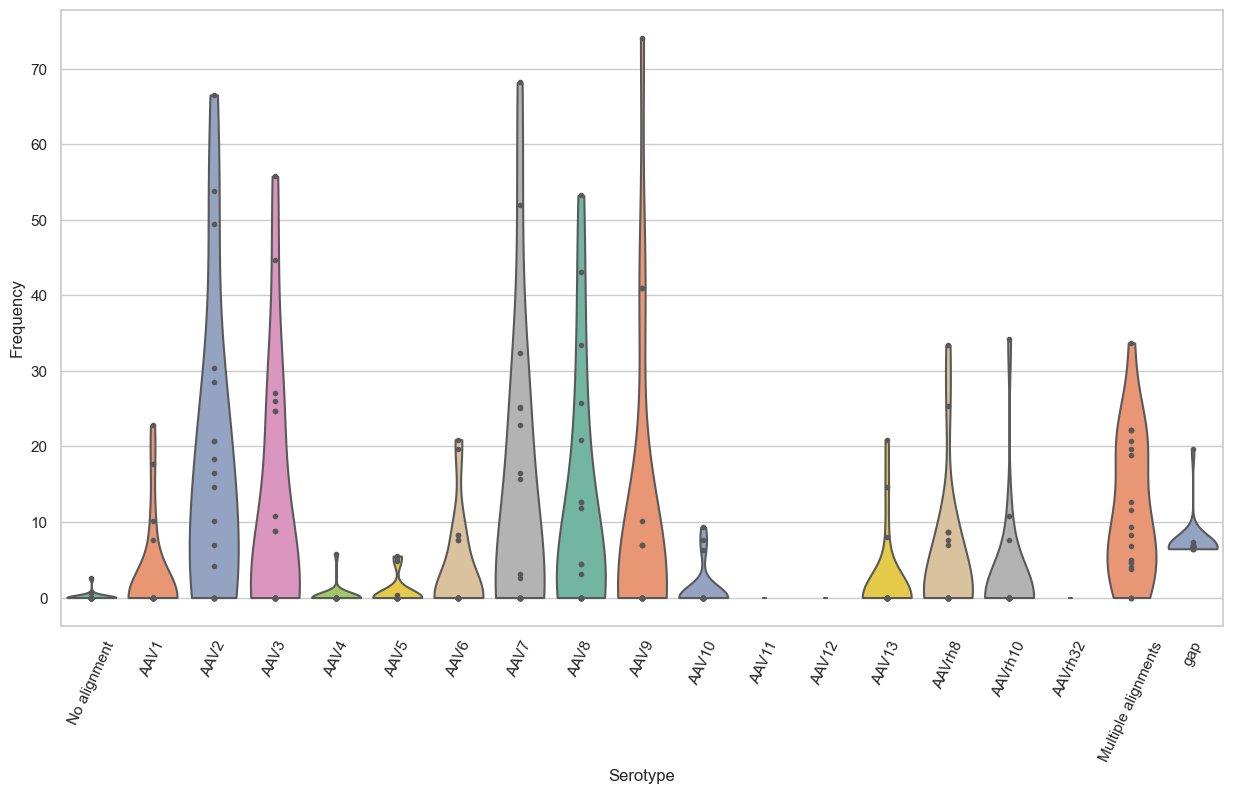

In [32]:
### Unfortunately bokeh has abandoned seaborn and matplotlib support (it seems). Maybe a boxplot after all?
### We will think how to do this better. I tried KDE estimates myself, but results looked very ugly.

sns.set_style("whitegrid")


ax = sns.violinplot(x = "Serotype", y = "Frequency",
                    data=serotype_dist_data_frame, palette = "Set2", split = True,
                    scale = "count", inner = "points", cut=0)

ax.tick_params(axis = 'x', rotation = 65)
sns.set(rc = {'figure.figsize':(15, 8)})

